<a href="https://colab.research.google.com/github/keyap22/Customer-Segmentation/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Overview

This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.



### Goal

Our aim is to segment the Customers based on RFM(Recency, Frequency, Monetary) so that the company can target its customers efficiently.

The steps are broadly divided into:

Step 1: Reading and Understanding the Data

Step 2: Data Cleaning

Step 3: Data Preparation

Step 4: Model Building

Step 5: Final Analysis

### Step 1 : Reading and Understanding Data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from dateutil import parser
from sklearn.preprocessing import StandardScaler
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/OnlineRetail.csv", encoding= 'unicode_escape')

FileNotFoundError: ignored

In [ ]:
df.info()

In [ ]:
df.describe()

###Attribute Information:

InvoiceNo: Invoice number.
Datatype - Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Datatype - Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Datatype - Nominal.

Quantity: The quantities of each product (item) per transaction. Datatype - Numeric.

InvoiceDate: Invoice Date and time. Datatype - Numeric, the day and time when each transaction was generated.

UnitPrice: Unit price. Datatype - Numeric, Product price per unit in sterling.

CustomerID: Customer number. Datatype - Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides.

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

### Step 2 : Data Cleaning

In [ ]:
df.isnull().sum()

In [ ]:
df.shape

In [ ]:
df.isnull().sum().sum()

     
     Dropping rows containing null values. Since, size of data is huge enough so it won't make much difference.

In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
# Changing the datatype of Customer Id as per Business understanding

df['CustomerID'] = df['CustomerID'].astype(str)

In [ ]:
# Convert to datetime to proper datatype

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')

Dropping rows having duplicate values

In [ ]:
df.shape

In [ ]:
df.drop_duplicates(keep=False,inplace=True)
df.shape

10147 duplicate rows dropped


In [ ]:
df.tail(250)

In [ ]:
df.nunique()      #count of unique values in attributes

In [ ]:
df.shape

Removing the cancelled transactions/orders



In [ ]:
df.drop(df[df['Quantity'] < 0].index, inplace = True)

In [ ]:
df.shape

9687 rows removed


In [ ]:
df.describe()

In [ ]:
corr = df.corr(method = 'pearson')

#convert correlation to numpy array
mask = np.array(corr)

#to mask the repetitive value for each pair
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots(figsize = (15,12))
fig.set_size_inches(15,15)
sns.heatmap(corr, mask = mask, vmax = 0.9, square = True, annot = True)

The heatmap shows "Quantity" and "UnitPrice" are weakly correlated with each other.

### Step 3 : Data Preparation

####We are going to analysis the Customers based on below 3 factors:

R (Recency): Number of days since last purchase

F (Frequency): Number of transactions wrt same customer(i.e. same CustomerId and same InvoiceNo)

M (Monetary): Total amount of transactions (revenue contributed)

In [ ]:
# New Attribute : Amount

df['Amount'] = df['Quantity']*df['UnitPrice']
retail = df.groupby('CustomerID')['Amount'].sum()
retail = retail.reset_index()
retail.head()

In [ ]:
# New Attribute : Frequency

retail_f = df.groupby('CustomerID')['InvoiceNo'].count()
retail_f = retail_f.reset_index()
retail_f.columns = ['CustomerID', 'Frequency']
retail_f.head()

In [ ]:
rfm = pd.merge(retail, retail_f, on='CustomerID', how='inner')
rfm.head()

New Attribute : Recency

In [ ]:
# Compute the maximum date to know the last transaction date

max_date = max(df['InvoiceDate'])
max_date

In [ ]:
# Compute the difference between max date and transaction date

df['Recency'] = max_date - df['InvoiceDate']
df.head()

In [ ]:
# Compute last transaction date of particular customer to get the recency of customers

rfm_p = df.groupby('CustomerID')['Recency'].min()
rfm_p = rfm_p.reset_index()

# Extract number of days only

rfm_p['Recency'] = rfm_p['Recency'].dt.days
rfm_p.head()

In [ ]:
# Merge the dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
#rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

In [ ]:
rfm.shape

####There are 2 types of outliers and we will treat outliers as it can skew our dataset
- Statistical
- Domain specific

In [ ]:
# Outlier Analysis of Amount, Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2")
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]
#

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [ ]:
# Outlier Analysis of Amount, Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2")
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
rfm.shape

79 rows containing outliers are removed

###Rescaling the Attributes
It is extremely important to rescale the variables so that they have a comparable scale.

There are two common ways of rescaling:

1. Min-Max scaling
2. Standardisation (mean-0, sigma-1)

Here, we will use Standardisation Scaling.

- Normalization scales each input variable separately to the range 0-1, which is the range for floating-point values where we have the most precision.

- Standardization scales each input variable separately by subtracting the mean (called centering) and dividing by the standard deviation to shift the distribution to have a mean of zero and a standard deviation of one.

In [ ]:
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

In [ ]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

In [ ]:
rfm_df_scaled.info()

## Step 4 : Building the Model

### K-Means Clustering
K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.


In [ ]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

In [ ]:
kmeans.labels_

### Finding the Optimal Number of Clusters
Elbow Curve to get the right number of Clusters

A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Elbow-curve/SSD
sse = {}
# Fit KMeans and calculate SSE for each k
for k in range(2, 9):

    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)

    # Fit KMeans on the normalized dataset
    kmeans.fit(rfm_df_scaled)

    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_
# Plotting the elbow plot
plt.figure(figsize=(12,8))
plt.title('The Elbow Method')
plt.xlabel('k');
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

There’s a sweet spot where the SSE curve starts to bend known as the elbow point.

In [ ]:
# model with k=3
kmeans = KMeans(n_clusters=3, max_iter=300)
kmeans.fit(rfm_df_scaled)

In [ ]:
rfm_df_scaled['Cluster_Id'] = kmeans.labels_ + 1
rfm_df_scaled.head(5)

In [ ]:
# Box plot to visualize Cluster Id vs Amount

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm_df_scaled)

Above boxplot indicates customer having cluster_id 2 will have more amount of transactions compared to remaining clusters.

In [ ]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm_df_scaled)

Above boxplot indicates customer having cluster_id 2 will have more number of transactions compared to remaining clusters.

In [ ]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm_df_scaled)

Above boxplot indicates customer having cluster_id 3 is having huge gap between his/her last transaction and retail company's last transaction compared to remaining clusters which is not good.

In [ ]:
groups = rfm_df_scaled.groupby('Cluster_Id')

In [ ]:
a = groups.get_group(1)
b = groups.get_group(2)
c = groups.get_group(3)

In [ ]:
a.shape, b.shape, c.shape     #total - 4257

In [ ]:
a.head()

In [ ]:
kmeans.cluster_centers_

### Visualisation of Clusters

In [ ]:
plt.scatter(a.iloc[:,0], a.iloc[:,1], s = 100, c = 'blue', label = 'Cluster 1')           #for first cluster
plt.scatter(b.iloc[:,0], b.iloc[:,1], s = 100, c = 'green', label = 'Cluster 2')          #for second cluster
plt.scatter(c.iloc[:,0], c.iloc[:,1], s = 100, c = 'red', label = 'Cluster 3')            #for third cluster

plt.scatter(kmeans.cluster_centers_[0,0], kmeans.cluster_centers_[0, 1], s = 300, c = 'yellow', label = 'Centroid1')
plt.scatter(kmeans.cluster_centers_[1,0], kmeans.cluster_centers_[1, 1], s = 300, c = 'grey', label = 'Centroid2')
plt.scatter(kmeans.cluster_centers_[2,0], kmeans.cluster_centers_[2, 1], s = 300, c = 'black', label = 'Centroid3')

plt.title('Visualization of diff. Clusters')
plt.xlabel('Amount and Frequency(InvoiceNo)')
plt.ylabel('Region')
plt.legend()
plt.show()

In [ ]:
plt.scatter(a.iloc[:,0], a.iloc[:,2], s = 100, c = 'blue', label = 'Cluster 1')           #for first cluster
plt.scatter(b.iloc[:,0], b.iloc[:,2], s = 100, c = 'green', label = 'Cluster 2')          #for second cluster
plt.scatter(c.iloc[:,0], c.iloc[:,2], s = 100, c = 'red', label = 'Cluster 3')            #for third cluster
plt.scatter(kmeans.cluster_centers_[0,0], kmeans.cluster_centers_[0, 1], s = 300, c = 'yellow', label = 'Centroid1')
plt.scatter(kmeans.cluster_centers_[1,0], kmeans.cluster_centers_[1, 1], s = 300, c = 'grey', label = 'Centroid2')
plt.scatter(kmeans.cluster_centers_[2,0], kmeans.cluster_centers_[2, 1], s = 300, c = 'black', label = 'Centroid3')

plt.title('Visualization of diff. Clusters', fontweight=30)
plt.xlabel('Amount and Recency(InvoiceDate)')
plt.ylabel('Region')
plt.legend()
plt.show()

In [ ]:
plt.scatter(a.iloc[:,1], a.iloc[:,2], s = 100, c = 'blue', label = 'Cluster 1')           #for first cluster
plt.scatter(b.iloc[:,1], b.iloc[:,2], s = 100, c = 'green', label = 'Cluster 2')          #for second cluster
plt.scatter(c.iloc[:,1], c.iloc[:,2], s = 100, c = 'red', label = 'Cluster 3')            #for third cluster
plt.scatter(kmeans.cluster_centers_[0,0], kmeans.cluster_centers_[0, 1], s = 300, c = 'yellow', label = 'Centroid1')
plt.scatter(kmeans.cluster_centers_[1,0], kmeans.cluster_centers_[1, 1], s = 300, c = 'grey', label = 'Centroid2')
plt.scatter(kmeans.cluster_centers_[2,0], kmeans.cluster_centers_[2, 1], s = 300, c = 'black', label = 'Centroid3')

plt.title('Visualization of diff. Clusters', fontweight=30)
plt.xlabel('Frequency(InvoiceNo) and Recency(InvoiceDate)')
plt.ylabel('Region')
plt.legend()
plt.show()

### Result:

We are able to divide customers into 3 groups based on RFM.

In [ ]:
plt.figure(figsize=(20,20))
px.scatter_3d(rfm_df_scaled, x="Amount", y="Frequency", z="Recency", color="Cluster_Id")

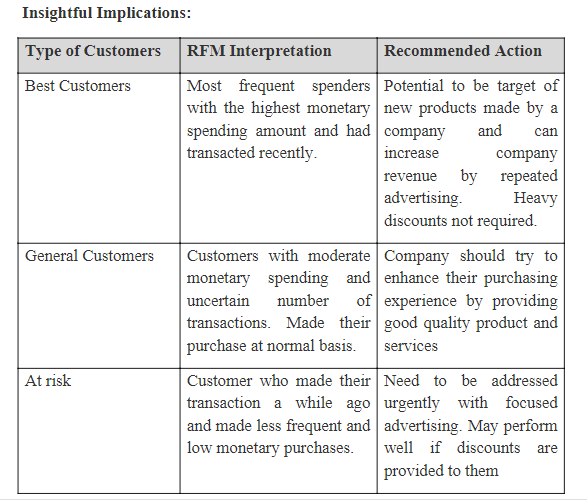

Customers belonging to 2nd cluster --> Best Customers

Customers belonging to 1st cluster --> General Customers

Customers belonging to 3rd cluster --> At risk Customers



**Conclusion**

Dataset was preprocessed and trained using the KMeans algorithm and as a final output, we obtained different clusters on the basis of RFM.